# Imports and function definitions

## Imports

In [11]:
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from spikeHelper.dataOrganization import trialToXyT,getX,XyTfromEpoch, normRows
import pickle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from spikeHelper.similarities import MahalanobisClassifier, temporalGeneralization,crossGeneralization
%matplotlib inline
from spikeHelper.loadSpike import Rat
import seaborn as sns

In [ ]:
from spikeHelper.dataOrganization import loadBestParams
from sklearn.svm import SVC
from spikeHelper.metrics import performanceFromConfusion
from sklearn.metrics import confusion_matrix

## Function definitions

In [12]:
def decoderPerformancePlot(wrapperBeg, wrapperEnd, rat, axs=[], metric = 'kappa'):
    parameters = loadBestParams(rat)

    if len(axs)==0:
        fig, axs=plt.subplots(5,1)
        fig.set_size_inches((5,20))
        
    ax=axs[0]; axGenBeg=axs[1]; axGenEnd=axs[2]; axNormGenBeg=axs[3]; axNormGenEnd=axs[4];
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(wrapperBeg.X, wrapperBeg.y, wrapperBeg.trial, clf,returnCubic=True)
    begDirect = performanceFromConfusion(aux,kind=metric,weights = 'quadratic')
   
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(wrapperEnd.X, wrapperEnd.y, wrapperEnd.trial, clf,returnCubic=True)
    endDirect = performanceFromConfusion(aux,kind=metric,weights = 'quadratic')
    
    tGen = temporalGeneralization(wrapperBeg.X, wrapperBeg.y, wrapperBeg.trial, clf,transform=True)
    aux,_ = crossGeneralization(wrapperBeg,wrapperEnd,rat)
    
    endTestCross = performanceFromConfusion(aux,kind=metric,weights = 'quadratic')
    axGenEnd.imshow(tGen,origin='bottom',cmap='viridis'); axGenEnd.set_title('Test end')
    axGenEnd.set_xlabel('Real') ; axGenEnd.set_ylabel('Predicted')
    axNormGenEnd.imshow(aux.mean(axis=2),origin='bottom',cmap='viridis'); axNormGenEnd.set_title('Test beg Normalized rows')
    
    
    tGen = temporalGeneralization(wrapperEnd.X, wrapperEnd.y, wrapperEnd.trial, clf,transform=True)
    aux, tGen = crossGeneralization(wrapperEnd,wrapperBeg,rat)
    begTestCross = performanceFromConfusion(aux,kind=metric,weights = 'quadratic')
    axGenBeg.imshow(tGen,origin='bottom',cmap='viridis'); axGenBeg.set_title('Test beg')
    axGenBeg.set_xlabel('Real') ; axGenBeg.set_ylabel('Predicted')
    axNormGenBeg.imshow(aux.mean(axis=2),origin='bottom',cmap='viridis'); axNormGenBeg.set_title('Test beg Normalized rows')

    
    ax.plot([0,1],[begDirect,endDirect], 'r-o', label='Direct')
    ax.plot([0,1],[begTestCross,endTestCross],'b-o', label='Cross')
    ax.legend(loc='upper right'); ax.set_xticks([0,1],['Beg','End']); #ax.set_ylim([0,1])

    [ax.set_aspect(aspect= 'auto') for ax in axs]
    return begDirect

def crossGeneralization(epochsTrain,epochsTest,rat):
    '''Trains on all of the first input, and tests in each of the second'''
    Xtrain, ytrain = epochsTrain.X, epochsTrain.y
    Xtest, ytest = epochsTest.X, epochsTest.y
    ytrial = epochsTest.trial


    parameters = loadBestParams(rat)
    clf = SVC(C=parameters['C'], gamma=10**parameters['logGamma'], decision_function_shape='ovr')
    clf.fit(Xtrain,ytrain)

    n_classes = max(len(np.unique(ytest)),len(np.unique(ytrain)) )
        
    trials = np.unique(epochsTest.trial)
    confusionPerTrial = np.full((n_classes,n_classes,trials.shape[0]), 0)
    for i,testTrial in enumerate(np.unique(ytrial)):
        ypred = clf.predict(Xtest[ytrial==testTrial, :])

        confusionPerTrial[:,:,i] = confusion_matrix(ytest[ytrial==testTrial], ypred,labels=np.arange(n_classes))

    ntrain, ntest = len(np.unique(ytrain)), len(np.unique(ytest))
    tempGen = np.full((ntrain,ntest),np.nan)
    for real_y in np.unique(ytest):
        tempGen[:,real_y-min(ytest)] = clf.decision_function(Xtest[ytest==real_y]).mean(axis=0)

    return confusionPerTrial,tempGen

In [13]:
def heatAct(wrapper,ax):
    data = wrapper.cubicNeuronTimeTrial()
    meanAct = np.nan_to_num(normRows(np.mean(data, axis=2)))
    order = np.argsort(np.nonzero(meanAct==1)[1])
    ax.imshow(meanAct[order,:],cmap='magma',origin='bottom')
    ax.set_yticks([],[]);ax.set_xticks([],[])
    ax.set_aspect(aspect= 'auto')
    return meanAct
    
def pcPlot(wrapperBeg,wrapperEnd,axg,axp):
    
    X, y = wrapperBeg.X, wrapperBeg.y
    pcs, exp= getMeanPC(X,y)
    for i,pc in enumerate(pcs):
        axg.plot(pc,'y', alpha=.05+ .95*(exp[i])/max(exp),linewidth=1+2*(exp[i]))
    axp.plot(np.cumsum(exp),'y',label='Beg. Dim: %d'%dim(exp))
    
    
    X, y = wrapperEnd.X, wrapperEnd.y
    pcs, exp = getMeanPC(X,y)
    for i,pc in enumerate(pcs):
        axg.plot(pc,'b', alpha=(exp[i])/max(exp),linewidth=1+2*(exp[i]))
    axp.plot(np.cumsum(exp),'b',label='End. Dim: %d'%dim(exp))
    
    axp.set_yticks([],[]);axp.set_xticks([],[])
    axp.legend(loc='lower right',markerscale=8,fontsize=8)
    axg.set_title('Componentes principais no tempo')
     
    
def getMeanPC(X,y):
    pca = PCA()
    pca.fit(X)
    endPca =[ pca.transform(X[y==i]) for i in np.unique(y)]
    pcs = np.array(list(map(lambda x: x.mean(axis=0), endPca))).transpose()
    exp = pca.explained_variance_ratio_
    return pcs, exp

def dim(explained_ratio):
    return np.nonzero(np.cumsum(explained_ratio)>.95)[0][0]

In [14]:
def removeTrialsWithMuchActivity(unitTimeTrialCubic, devs = 2):
    trialActivity = unitTimeTrialCubic.sum(axis=1).mean(axis=0)
    base = np.median(trialActivity)
    threshold = base + devs*trialActivity.std()
    print('Removing %d trials' %(trialActivity > threshold).sum())
    
    return unitTimeTrialCubic[:,:,trialActivity < threshold]

def removeNeuronsThatDoNotFire(unitTimeTrialCubic,threshold = 10):
    trialActivity = unitTimeTrialCubic.mean(axis=2).sum(axis=1)
    print('Removing %d neurons' %(trialActivity < threshold).sum())
    
    return unitTimeTrialCubic[trialActivity > threshold,:,:]

In [15]:
from sklearn.covariance import EmpiricalCovariance
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance

def plotCovariance(wrapper,ax):
    empCov = EmpiricalCovariance()
    empCov.fit(wrapper.X)
    ax.imshow(empCov.covariance_,cmap='cool')
    
def plotCovariance2(data,ax):
    cov = Covariances()
    cov = cov.transform(data.cubicNeuronTimeTrial().transpose().swapaxes(1,2))
    ax.imshow(cov.mean(axis=0),cmap='cool')

In [16]:
def intPlot(beg, end,rat, performance = True,metric = 'kappa'):
    fig=plt.figure(figsize=(10,10))
    grid = plt.GridSpec(4,4)

    # Principal components
    axg = plt.subplot(grid[0,0:2])
    axp = inset_axes(axg,height="40%",width="40%",loc=2)
    pcPlot(beg,end,axg,axp)
    
    # Time cells
    axp2= plt.subplot(grid[0,2])
    axp3= plt.subplot(grid[0,3])

    
    heatAct(beg,axp2);axp2.set_xlabel('Beg')#set_title('Beg')
    heatAct(end,axp3);axp3.set_xlabel('End')#set_title('End')
    axp2.set_title('Time Cells')
    
    # Spikes per trial inicio
    axp4= plt.subplot(grid[1,0])
    axp4.imshow(normRows(beg.cubicNeuronTimeTrial().mean(axis=1)),cmap='inferno',origin='bottom')
    axp4.set_yticks([],[]);axp4.set_xticks([],[]);
    axp4.set_aspect(aspect= 'auto')
    axp4.set_title('Spikes/trial inicio')
    
    # Spikes per trial fim
    axp4= plt.subplot(grid[1,1])
    axp4.imshow(normRows(end.cubicNeuronTimeTrial().sum(axis=1)),cmap='inferno',origin='bottom')
    axp4.set_yticks([],[]);axp4.set_xticks([],[]);
    axp4.set_aspect(aspect= 'auto')
    axp4.set_title('Spikes/trial fim')
    
    # Similaridade mahalanobis começo
    tgenBeg = plt.subplot(grid[1,2])
    clf=MahalanobisClassifier(warm_start=True)
    sim = temporalGeneralization(beg.X,beg.y,beg.trial,clf,transform=True)
    tgenBeg.imshow(sim,origin='bottom');#tgenBeg.set_yticks([],[]);tgenBeg.set_xticks([],[]);
    tgenBeg.set_title('Similaridade')
    # Normalizada
    tgenBegNorm = plt.subplot(grid[2,2])
    tgenBegNorm.imshow(normRows(sim),origin='bottom')
    
    # Similaridade mahalanobis fim
    tgenEnd = plt.subplot(grid[1,3])
    clf=MahalanobisClassifier(warm_start=True)
    sim = temporalGeneralization(end.X,end.y, end.trial, clf,transform=True)
    tgenEnd.imshow(sim,origin='bottom');#tgenEnd.set_yticks([],[]);tgenEnd.set_xticks([],[]);
    # Normalizada
    tgenEndNorm = plt.subplot(grid[2,3])
    tgenEndNorm.imshow(normRows(sim),origin='bottom')
    
    # Covariancia
    plotCovariance2(beg,plt.subplot(grid[1,2]))
    plotCovariance2(end,plt.subplot(grid[1,3]))
    
    if performance:
        perf = plt.subplot(grid[2,0:2])
        axGenEnd = plt.subplot(grid[3,1])
        axGenBeg = plt.subplot(grid[3,0])
        axNormGenBeg = plt.subplot(grid[3,2])
        axNormGenEnd = plt.subplot(grid[3,3])
        decoderPerformancePlot(beg, end, rat, [perf,axGenBeg,axGenEnd,axNormGenBeg,axNormGenEnd],metric=metric)
    
    fig.suptitle('Atividade rato %d'%rat)
    
    #grid.tight_layout(fig)
    

# Analysis

## Behavior and performance

In [ ]:
end = Rat(rat,binSize=50); end.selecTrials({'minDuration':1800,'maxDuration':4000,'ntrials':50,'minTrial':'best'});
end.selecTimes(tmin = 0, tmax=3000)

In [10]:
rat = 8
beg = Rat(rat,binSize=100); beg.selecTrials({'minDuration':1800,'maxDuration':4000,'ntrials':80}); 
beg.selecTimes(tmin = 0, tmax=1500)
beg.describe()

parameters = loadBestParams(rat)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
cubic = temporalGeneralization(beg.X, beg.y, beg.trial,clf,returnCubic=True)


Label: Rat 8
Bin size: 100
Sigma: 100

Using 80 trials, according to following restrictions:
minDuration: 1800
maxDuration: 4000
ntrials: 80

Using 15 time bins:
From 0 to 100ms
From 100 to 200ms
From 200 to 300ms
.
.
.
From 1300 to 1400ms
From 1400 to 1500ms


In [175]:
performanceFromConfusion(cubic)

0.5051769372967978

In [12]:
plt.figure(figsize=(10,10))
sns. scatter(x=0,y='index',data=behav, hue='higher')
plt.xticks(np.arange(0,4000,500),np.arange(0,4000,500))

AttributeError: module 'seaborn' has no attribute 'scatter'

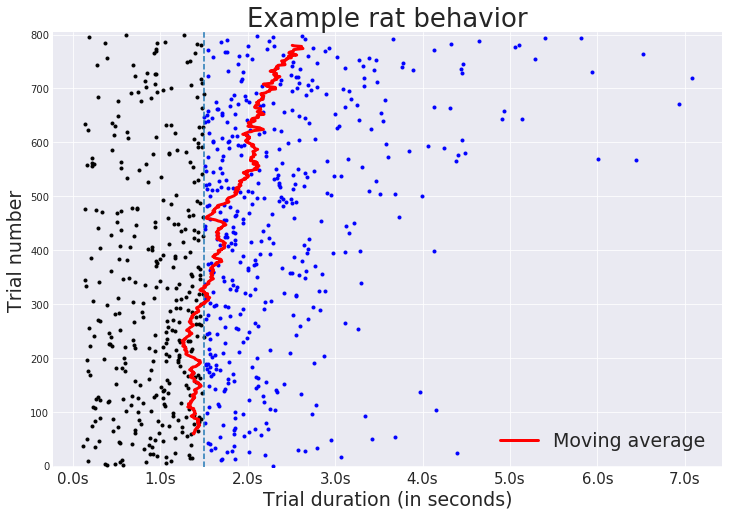

In [103]:
beg = Rat(rat,binSize=100);
behav = pd.DataFrame(beg._trialSpecs['Trial duration']).reset_index()
behav['higher'] = behav[0].apply(lambda x: x > 1500)

plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
plt.plot(behav[behav['higher']==True][0].values,behav[behav['higher']==True]['index'].values,'b.');
plt.plot(behav[behav['higher']==False][0].values,behav[behav['higher']==False]['index'].values,'k.');
plt.xlabel('Trial duration (in seconds)',fontsize=19);plt.ylabel('Trial number',fontsize=19);
plt.axvline(1500,0,800,linestyle='--')
plt.xticks(np.arange(0,8000,1000),[str(t)+'s' for t in np.arange(0,8000,1000)/1000],fontsize=15);

media = behav[0].rolling(80).apply(np.mean).values[40:]
plt.plot(media,np.arange(20,781),'r',label='Moving average',linewidth=3)
plt.legend(loc='lower right',fontsize=19)
plt.ylim([-3,804]); plt.title('Example rat behavior',fontsize=26)

In [292]:
from scipy.io import loadmat
g = loadmat('Data/gcells_R8_2.mat')

In [293]:
np.nonzero(g['gcelR8'].ravel())[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 44, 51,
       52, 59, 62])

In [294]:
spk, bhv = loadSpikeBehav('Data/rato8tudo.mat')
bonsNeurons = np.nonzero(g['gcelR8'].ravel())[0]
spikes = pd.DataFrame([np.hstack(spk.trialTime.values[bonsNeurons]),np.hstack(spk.trial.values[bonsNeurons])],index=['Spike time','Trial'])
spikes = spikes.transpose()

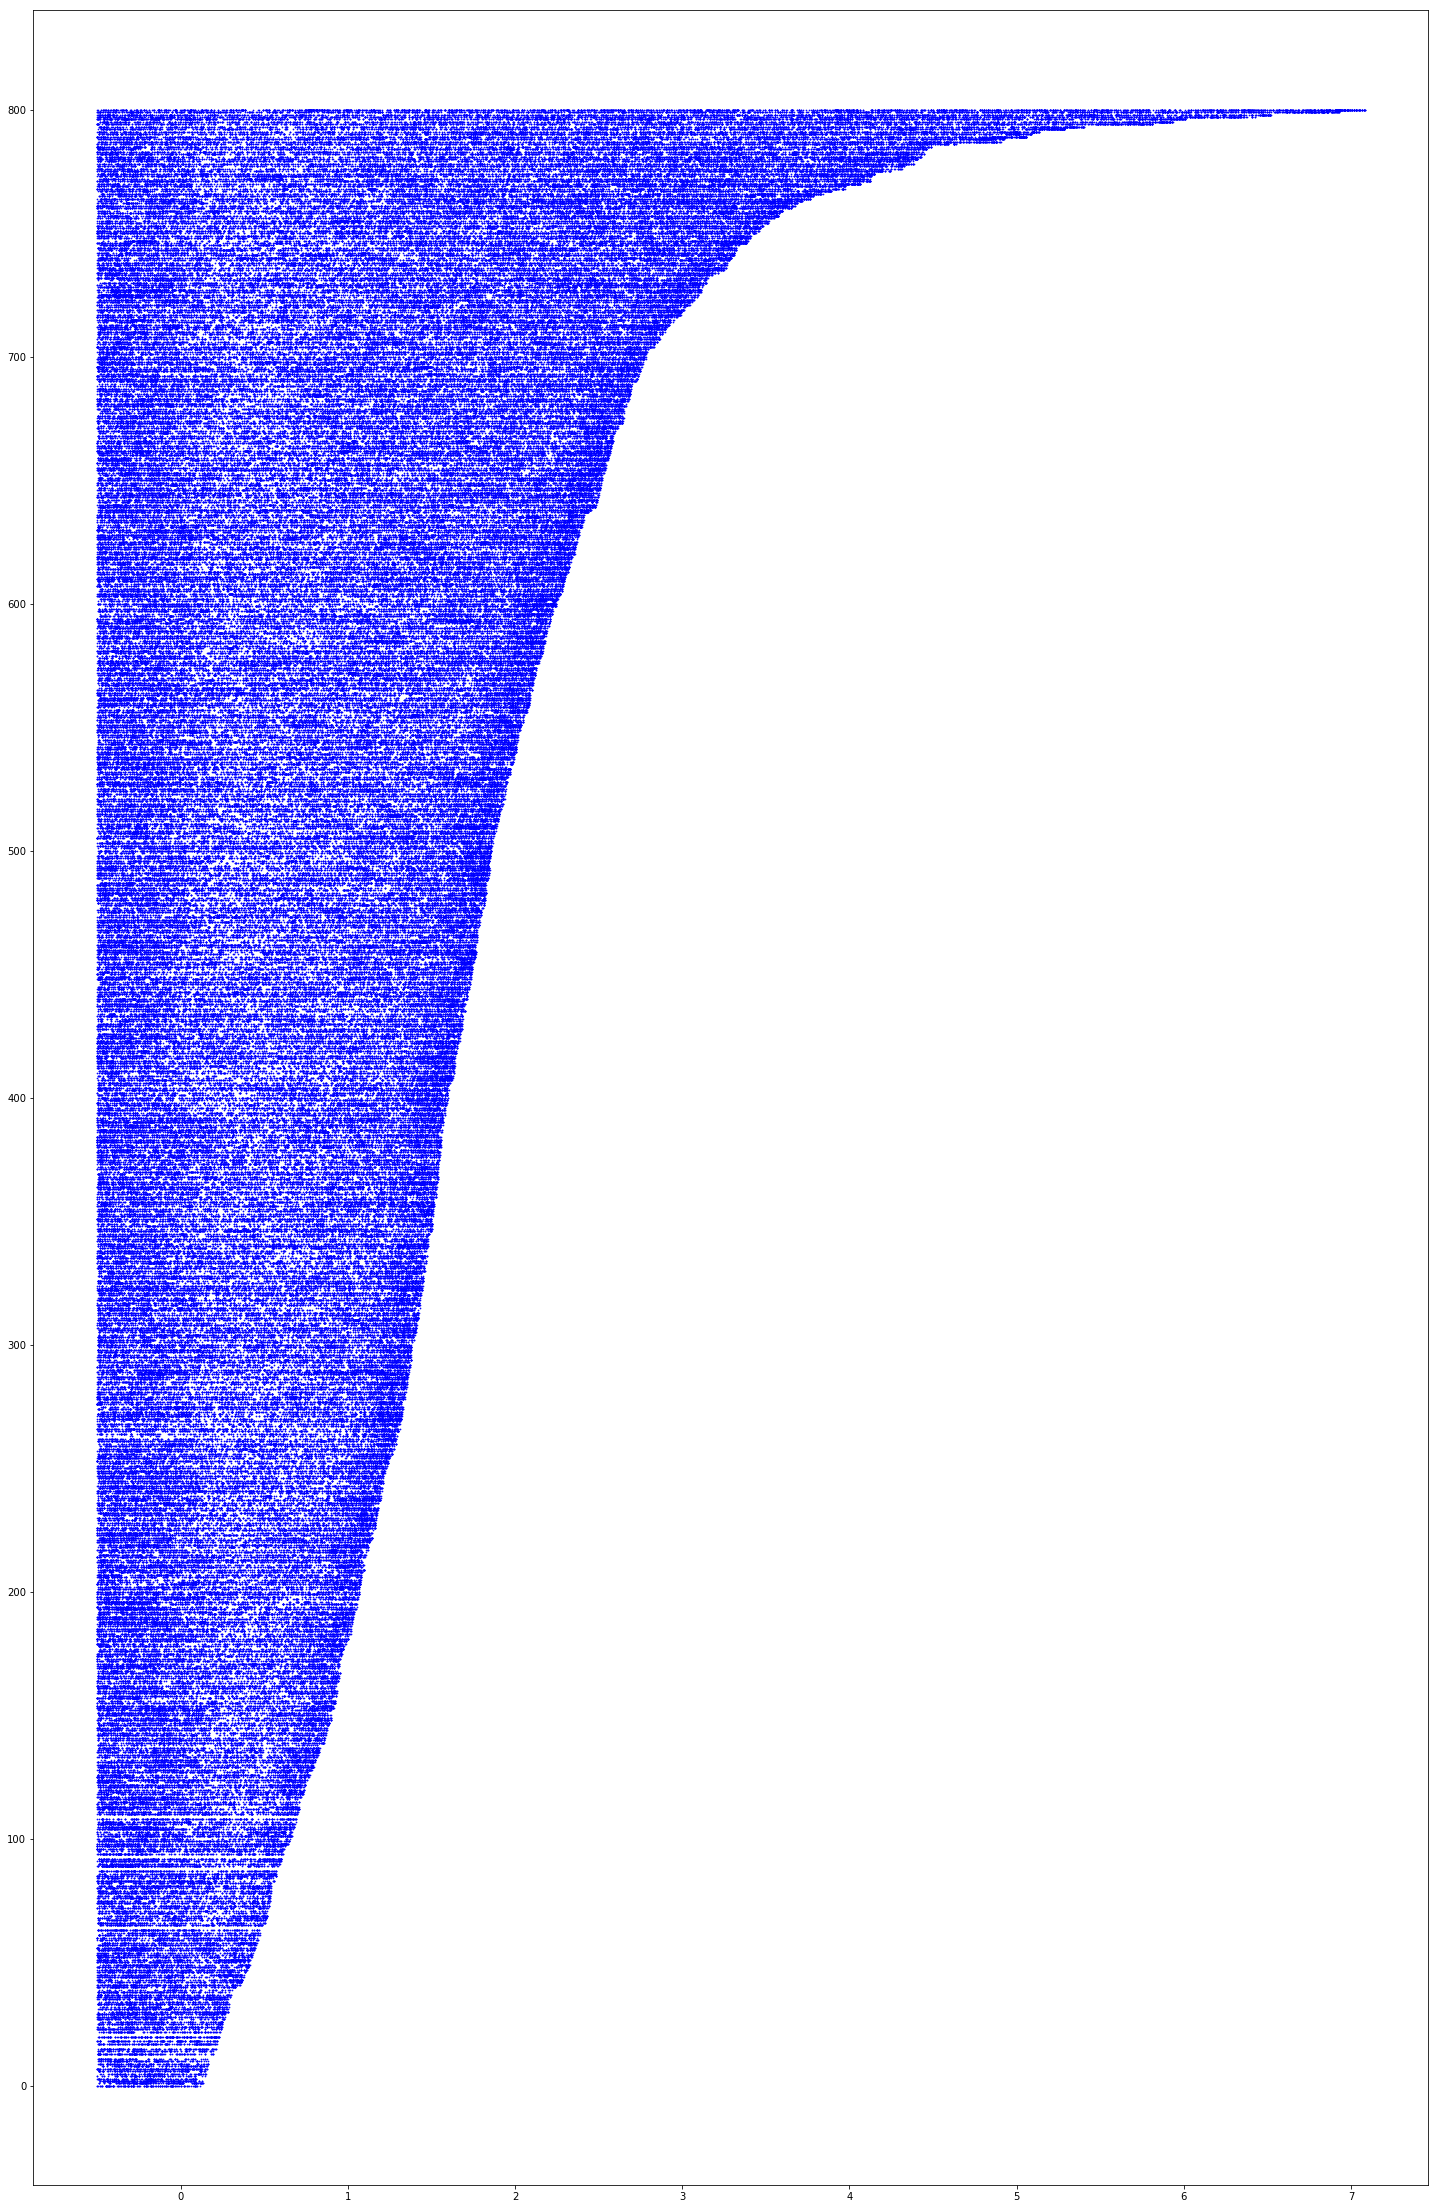

In [306]:
plt.figure(figsize=(25,40))
for i,j in enumerate(bhv.duration.sort_values().index):
    trialspikes = spikes[spikes['Trial']==j+1]['Spike time']
    plt.scatter(trialspikes,i*np.ones(len(trialspikes)),color = 'b',s = .5)

In [252]:
bhv.duration.sort_values(ascending=False).index

0

In [201]:
from spikeHelper.loadSpike import loadSpikeBehav

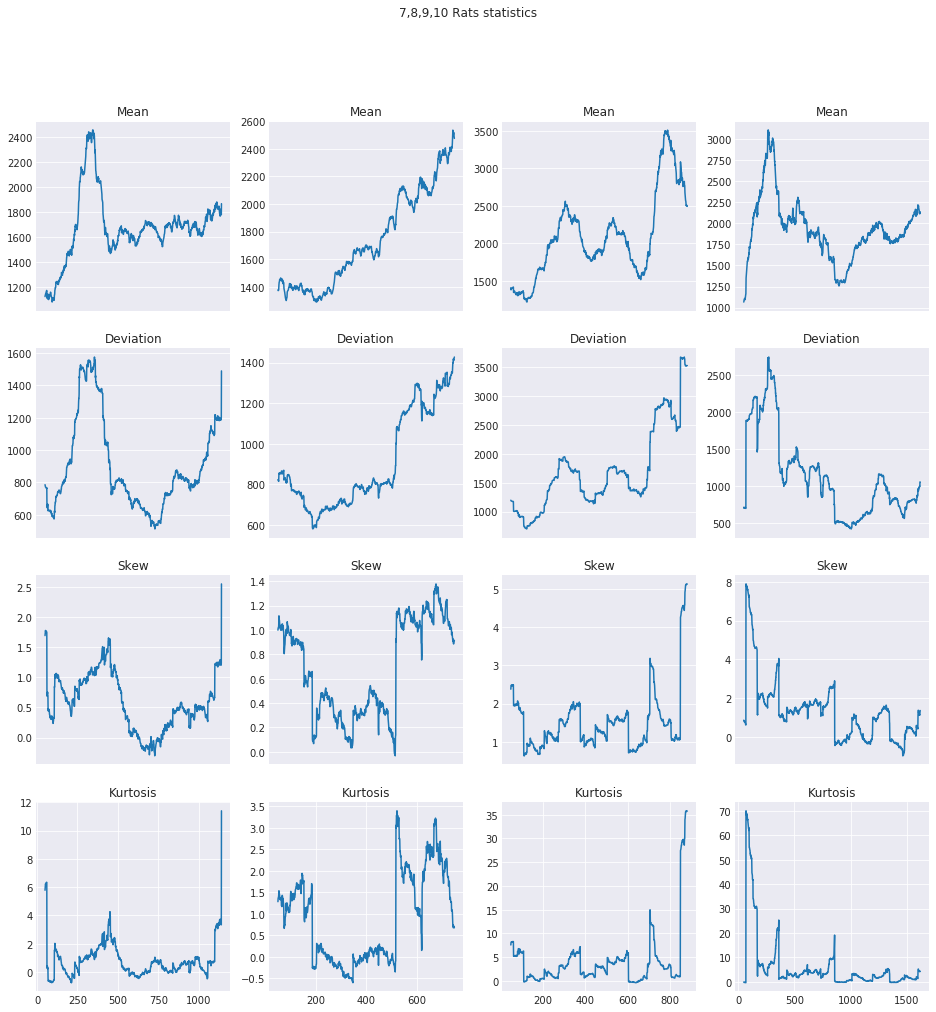

In [97]:
import scipy.stats as st
beg=Rat(7)
behav = pd.DataFrame(beg._trialSpecs['Trial duration']).reset_index()

plt.figure(figsize=(16,16))
rollingWindow = 100
x = np.arange(behav.shape[0])-rollingWindow/2
plt.subplot(4,4,1)
plt.plot(x,behav.rolling(rollingWindow).apply(np.mean)[0]);plt.title('Mean');plt.xticks([])
plt.subplot(4,4,5)
plt.plot(x,behav.rolling(rollingWindow).apply(np.std)[0]);plt.title('Deviation');plt.xticks([])
plt.subplot(4,4,9)
plt.plot(x,behav.rolling(rollingWindow).apply(lambda x: st.skew(x,bias=True))[0]);plt.title('Skew');plt.xticks([])
plt.subplot(4,4,13)
plt.plot(x,behav.rolling(rollingWindow).apply(st.kurtosis)[0]);plt.title('Kurtosis')

plt.suptitle('Rat 7 statistics')

beg=Rat(8)
behav = pd.DataFrame(beg._trialSpecs['Trial duration']).reset_index()


x = np.arange(behav.shape[0])-rollingWindow/2
plt.subplot(4,4,2)
plt.plot(x,behav.rolling(rollingWindow).apply(np.mean)[0]);plt.title('Mean');plt.xticks([])
plt.subplot(4,4,6)
plt.plot(x,behav.rolling(rollingWindow).apply(np.std)[0]);plt.title('Deviation');plt.xticks([])
plt.subplot(4,4,10)
plt.plot(x,behav.rolling(rollingWindow).apply(lambda x: st.skew(x,bias=True))[0]);plt.title('Skew');plt.xticks([])
plt.subplot(4,4,14)
plt.plot(x,behav.rolling(rollingWindow).apply(st.kurtosis)[0]);plt.title('Kurtosis')

plt.suptitle('Rat 8 statistics')

beg=Rat(9)
behav = pd.DataFrame(beg._trialSpecs['Trial duration']).reset_index()


x = np.arange(behav.shape[0])-rollingWindow/2
plt.subplot(4,4,3)
plt.plot(x,behav.rolling(rollingWindow).apply(np.mean)[0]);plt.title('Mean');plt.xticks([])
plt.subplot(4,4,7)
plt.plot(x,behav.rolling(rollingWindow).apply(np.std)[0]);plt.title('Deviation');plt.xticks([])
plt.subplot(4,4,11)
plt.plot(x,behav.rolling(rollingWindow).apply(st.skew)[0]);plt.title('Skew');plt.xticks([])
plt.subplot(4,4,15)
plt.plot(x,behav.rolling(rollingWindow).apply(st.kurtosis)[0]);plt.title('Kurtosis')

plt.suptitle('Rat 9 statistics')

beg=Rat(10)
behav = pd.DataFrame(beg._trialSpecs['Trial duration']).reset_index()


x = np.arange(behav.shape[0])-rollingWindow/2
plt.subplot(4,4,4)
plt.plot(x,behav.rolling(rollingWindow).apply(np.mean)[0]);plt.title('Mean');plt.xticks([])
plt.subplot(4,4,8)
plt.plot(x,behav.rolling(rollingWindow).apply(np.std)[0]);plt.title('Deviation');plt.xticks([])
plt.subplot(4,4,12)
plt.plot(x,behav.rolling(rollingWindow).apply(st.skew)[0]);plt.title('Skew');plt.xticks([])
plt.subplot(4,4,16)
plt.plot(x,behav.rolling(rollingWindow).apply(st.kurtosis)[0]);plt.title('Kurtosis')

plt.suptitle('7,8,9,10 Rats statistics')

In [25]:
np.nonzero(data.trialsToUse)[0][-160:]

array([519, 520, 523, 524, 525, 528, 532, 533, 536, 537, 538, 539, 540,
       541, 543, 546, 549, 550, 551, 555, 561, 565, 566, 568, 569, 570,
       573, 574, 576, 577, 581, 582, 584, 587, 589, 593, 594, 595, 596,
       597, 599, 604, 605, 607, 611, 612, 614, 616, 619, 621, 623, 624,
       625, 626, 627, 630, 636, 640, 641, 642, 643, 644, 646, 648, 652,
       653, 654, 656, 657, 658, 660, 663, 665, 666, 668, 669, 670, 671,
       672, 673, 674, 678, 679, 680, 681, 683, 686, 687, 688, 690, 691,
       695, 696, 698, 699, 700, 703, 704, 705, 706, 709, 711, 712, 713,
       715, 716, 717, 719, 720, 721, 722, 725, 729, 730, 731, 732, 734,
       735, 736, 737, 738, 739, 740, 741, 742, 745, 746, 747, 748, 750,
       752, 753, 754, 755, 757, 759, 760, 761, 762, 763, 764, 769, 772,
       774, 775, 776, 777, 778, 779, 781, 782, 788, 789, 791, 792, 793,
       794, 795, 797, 798])

## Temporal generalization of classifier via readouts

### Without shuffling bins

In [27]:
rat = 8
notShuffled = Rat(rat,binSize=50); 
notShuffled.selecTrials({'minDuration':1300,'ntrials':160})
notShuffled.selecTimes(tmin=200,tmax=1000)
notShuffled.describe()

Label: Rat 8
Bin size: 50
Sigma: 100

Using 160 trials, according to following restrictions:
minDuration: 1300
ntrials: 160

Using 16 time bins:
From 200 to 250ms
From 250 to 300ms
From 300 to 350ms
.
.
.
From 900 to 950ms
From 950 to 1000ms


In [39]:
parameters = loadBestParams(rat)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
aux = temporalGeneralization(notShuffled.X, notShuffled.y, notShuffled.trial, clf,returnDecisionFunc=True,returnCubic=True)

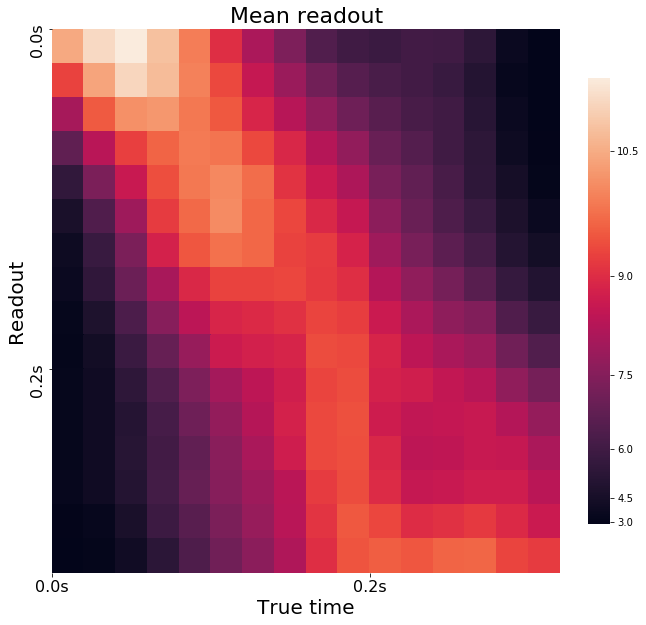

In [40]:
plt.figure(figsize=(10,10))
from matplotlib import colors
sns.heatmap(aux.mean(axis=2),norm=colors.PowerNorm(gamma=4./2.),cbar_kws={'fraction':.04})
plt.title('Mean readout',fontsize=22)
xt = np.arange(0,aux.shape[0]+4,10)
plt.xticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16)
plt.yticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16)
plt.xlabel('True time',fontsize=20);
plt.ylabel('Readout',fontsize=20);

### With bin shuffling

In [1]:
from spikeHelper.loadSpike import Rat
import h5py

In [5]:
shufRat = Rat(8,binSize=50, label = 'shuffled 8')

shuffled 8 not contained in database. Creating group
bin50_sigma100 not contained in database. Creating dataset.


In [ ]:
for shuf in range(10)
    shufRat._create('shuffle'+str(shuf)+'_bin50_sigma100', f, shuffleBins=True)

In [6]:
shufRat.describe

Label: shuffled 8
Bin size: 50
Sigma: 100

No selected trials.

Time bins not selected.


In [28]:
rat = 8
shuffledRat = Rat(rat,binSize=50,label = 'shuffled 8'); 
shuffledRat.selecTrials({'minDuration':1300,'ntrials':160})
shuffledRat.selecTimes(tmin=200,tmax=1000)
shuffledRat.describe()

Label: shuffled 8
Bin size: 50
Sigma: 100

Using 160 trials, according to following restrictions:
minDuration: 1300
ntrials: 160

Using 16 time bins:
From 200 to 250ms
From 250 to 300ms
From 300 to 350ms
.
.
.
From 900 to 950ms
From 950 to 1000ms


In [83]:
print((shuffledRat.cubicNeuronTimeTrial() == notShuffled.cubicNeuronTimeTrial()).sum() )
print((shuffledRat.cubicNeuronTimeTrial() != notShuffled.cubicNeuronTimeTrial()).sum() )

86578
8142


In [90]:
dif = np.where((shuffledRat.cubicNeuronTimeTrial() != notShuffled.cubicNeuronTimeTrial()))

In [50]:
(shuffledRat.X[np.logical_and(shuffledRat.X>0, not np.isnan(shuffledRat.X))] != notShuffled.X[np.logical_and(shuffledRat.X>0, not np.isnan(shuffledRat.X))]).sum()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [19]:
parameters = loadBestParams(rat)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
aux = temporalGeneralization(data.X, data.y, data.trial, clf,returnDecisionFunc=True,returnCubic=True)

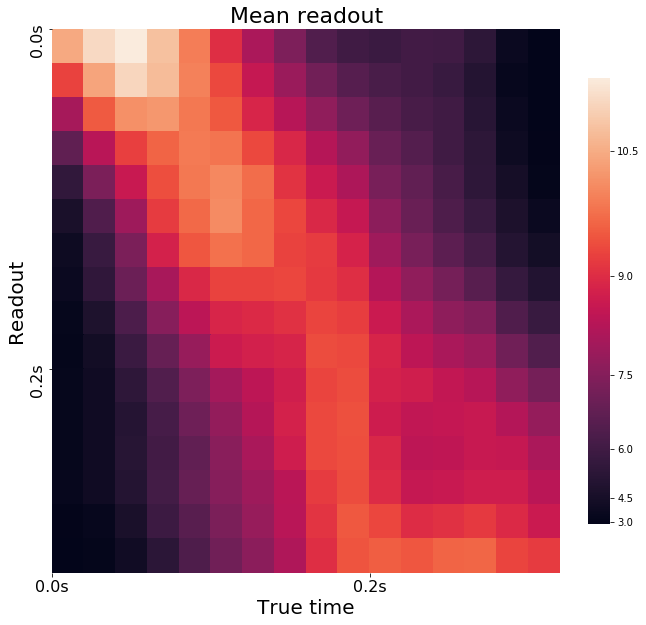

In [20]:
plt.figure(figsize=(10,10))
from matplotlib import colors
sns.heatmap(aux.mean(axis=2),norm=colors.PowerNorm(gamma=4./2.),cbar_kws={'fraction':.04})
plt.title('Mean readout',fontsize=22)
xt = np.arange(0,aux.shape[0]+4,10)
plt.xticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16)
plt.yticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16)
plt.xlabel('True time',fontsize=20);
plt.ylabel('Readout',fontsize=20);


# Testing shuffling

## Functions

In [120]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import pickle
from spikeHelper.filters import convHist, kernelSmooth, binarize
from spikeHelper.dataOrganization import XyTfromEpoch, padNans
import h5py

def precisionConvBin(spikeTimes,tmax,sigma,binSize):
    spikeVec = serializeSpikes(spikeTimes,tmax)
    spikeProb = convHist(spikeVec, sigma=sigma,binSize=binSize)
    return spikeProb

def serializeSpikes(spikeTimes, tmax, tmin=-500, dt=1):
    spikes = np.zeros(tmax-tmin)
    spikeTimeInMS = np.floor(spikeTimes*1000/dt) - tmin -1
    spikes[np.array(spikeTimeInMS,dtype=int)] = 1
    return spikes

def filterEpochs(epochs, minFiringRate= 4, minISI=5,method = 'premade', rat = None):
    if method == 'blind':
        goodFR = (epochs.applymap(lambda x: np.sum(x[500:])).mean(axis=1)>minFiringRate).values
        # Dump all neurons that have mean of 1 TOO FAST SPIKE per trial
        goodISI = (epochs.applymap(lambda x: np.histogram(np.diff(np.nonzero(x)),bins = minISI, range = (0,minISI))[0].sum() ).mean(axis=1) < 2).values
        return epochs.iloc[np.logical_and(goodFR,goodISI),:]
    elif method == 'premade':
        assert rat is not None
        goodNeurons = pickle.load(open('Data/goodCellsR'+str(rat)+'_withBaseDiff','rb'))==1
        return epochs.iloc[goodNeurons,:]
    else:
        raise('Nao existe metodo '+ str(method))


def mymax(x, tmin = -.5):
    try:
        return x.max()
    except:
        return tmin
def loadSpikeBehav(fileName):
    data = loadmat(fileName)

    spikes = data['dados'][0,0][1]
    behavior = data['dados'][0,0][0]

    spikes = pd.DataFrame([[ spikes[0,i][0][:,0], spikes[0,i][0][:,1]] for i in range(spikes.shape[1]) if spikes[0,i][0].shape[1]==2], columns=['times','trial'])
    behavior = pd.DataFrame(np.transpose(behavior[0,0][0]), columns=['one','onset','offset','zero','duration','sortIdx','sortLabel'])
    spikes['trialTime'] = pd.DataFrame(np.transpose([spikes.times[i] - behavior.iloc[spikes.trial[i]-1].onset.as_matrix() for i in range(spikes.shape[0])]))

    return spikes, behavior

def epochData(spikes, behavior, ratNumber, sigma, binSize, shuffleBins = False):
    epochs = np.array([[spikes.trialTime[iunit][spikes.trial[iunit]==itrial] for itrial in range(1,behavior.shape[0]+1)] for iunit in range(spikes.shape[0]) ] )
    epochs = pd.DataFrame(epochs, index = ['unit'+str(i) for i in range(spikes.shape[0])], columns = ['trial '+str(i) for i in range(1,behavior.shape[0]+1)])

    # Make sure spike times are consistent with trial durations
    assert ((1000*epochs.apply(lambda x: x.apply(mymax)).max()//1  - np.array([int(1000*behavior.duration[itrial]) for itrial in range(behavior.shape[0])]))>0).sum() == 0

    # Get only selected neurons
    epochs = filterEpochs(epochs, method='premade', rat=ratNumber)


    if binSize == 'norm':
        for itrial in range(1,behavior.shape[0]+1):
            trialSize = int(1000*behavior.duration[itrial-1])
            binSize = int(np.floor((trialSize)/10))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: serializeSpikes(x, trialSize))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: kernelSmooth(x, sigma))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: x[500:])
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: binarize(x, binSize))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: x*100/binSize)
    elif shuffleBins:
        for itrial in range(1,behavior.shape[0]+1):
            trialSize = int(np.floor(1000*behavior.duration[itrial-1]))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: serializeSpikes(x, trialSize))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply( np.random.permutation ) #shuffling before smoothi
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: kernelSmooth(x, sigma))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: binarize(x, binSize))
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(lambda x: x*100/binSize)
    else:
        for itrial in range(1,behavior.shape[0]+1):
            func = lambda x: precisionConvBin(x, int(np.floor(1000*behavior.duration[itrial-1])), sigma, binSize)
            epochs['trial '+str(itrial)] = epochs['trial '+str(itrial)].apply(func)
        # Make sure duration is consistent
        assert all(np.floor((.5+ behavior.duration)*(1000/binSize))==epochs.applymap(len).iloc[0].values)

    return epochs

## Running code

In [131]:
spikes, behavior = loadSpikeBehav('Data/rato8tudo.mat')
notShuffled = epochData(spikes, behavior, 8, 50, 100, shuffleBins = False)
shuffledRat = epochData(spikes, behavior, 8, 50, 100, shuffleBins = True)

In [132]:
(shuffledRat.applymap(sum) - notShuffled.applymap(sum)).head()

trial 1   trial 2   trial 3   trial 4   trial 5   trial 6  \
unit0 -6.283820e+00  3.309754 -4.481907  3.867783  2.533981  2.134238   
unit1 -7.105427e-15  2.111751 -0.978848 -1.953038 -0.007465  0.000000   
unit2 -3.306057e+00 -0.218454  1.421654 -0.361679 -2.785145  1.056351   
unit3 -4.727954e+00  2.913646  1.491240 -0.988502  8.546410  0.000000   
unit4 -4.640128e+00  2.788075  2.363082  2.581382  3.379106 -3.676514   

        trial 7   trial 8   trial 9  trial 10      ...       trial 792  \
unit0  2.235432  3.529071 -1.479079  1.493205      ...       -3.879044   
unit1 -4.441791  0.141812 -1.758021  5.862913      ...        0.000000   
unit2 -2.986183  1.603715  2.016582  0.295982      ...       10.929352   
unit3  1.562370  1.862971 -0.032272  3.344889      ...       -9.796955   
unit4 -0.389824 -6.072017  4.381887  1.487867      ...        0.609451   

       trial 793  trial 794  trial 795  trial 796  trial 797     trial 798  \
unit0  -0.156209   8.222707  13.284836   1.346763        0.0  4.276450e+00   
unit1  -0.531236   4.506294   0.040892  -0.153476        0.0  1.421085e-14   
unit2   0.989945   3.356104   8.208767   2.328572        0.0  1.965796e+00   
unit3  -9.454612   9.411504   7.214184  -3.510302        0.0 -9.517094e-01   
unit4  -0.224801   0.901264   6.719110  -3.336908        0.0 -2.910709e+00   

       trial 799  trial 800     trial 801  
unit0  -8.050955        0.0 -4.510794e+00  
unit1   0.310231        0.0  1.421085e-14  
unit2  -4.651909        0.0  5.506796e-01  
unit3  -5.355595        0.0  5.773841e-01  
unit4  -0.013304        0.0  7.848601e-01  

[5 rows x 801 columns]

In [133]:
shuffledRat.applymap(sum).head()

trial 1     trial 2     trial 3    trial 4     trial 5     trial 6  \
unit0  171.929670  108.334198   68.709533  29.821909   71.831177  125.738015   
unit1   39.762545  112.555350   18.902424  97.453324   19.873807    0.000000   
unit2  233.593915   59.387494   19.881272  69.099812   74.514615   86.953784   
unit3  392.022208  127.404919  145.129201  18.755214   77.622856   59.643817   
unit4  203.978468   59.643817   58.534897  66.542773  107.699715   95.002824   

         trial 7    trial 8    trial 9    trial 10     ...       trial 792  \
unit0  69.584453  58.916794   8.380480  158.276292     ...      155.026337   
unit1   5.447903  57.126140  57.882970   39.762545     ...      168.990815   
unit2  36.776361  89.058214  29.818022  109.346998     ...      288.278449   
unit3  86.195391  99.347831   9.908365   79.394990     ...      362.464638   
unit4   9.550812  71.842331  49.387644  143.535685     ...      165.500559   

        trial 793   trial 794   trial 795   trial 796  trial 797   trial 798  \
unit0  205.229415  437.347099  377.487852  194.161222        0.0  315.881774   
unit1  118.756399   99.244400  129.228270   29.668433        0.0   59.643817   
unit2  207.774512  523.478557  437.380527  258.267098        0.0  263.805456   
unit3  485.446609  864.276733  874.610716  286.717462        0.0  499.938327   
unit4  238.335485  364.207903  318.100358  151.292184        0.0  245.284055   

        trial 799  trial 800   trial 801  
unit0  150.727617        0.0  119.784204  
unit1   69.584453        0.0   89.465726  
unit2  203.321041        0.0  108.566566  
unit3  360.115686        0.0  134.101320  
unit4  149.096238        0.0   49.703181  

[5 rows x 801 columns]

In [134]:
notShuffled.applymap(sum).head()

trial 1     trial 2     trial 3    trial 4     trial 5     trial 6  \
unit0  178.213490  105.024444   73.191441  25.954125   69.297196  123.603777   
unit1   39.762545  110.443599   19.881272  99.406362   19.881272    0.000000   
unit2  236.899972   59.605948   18.459619  69.461491   77.299761   85.897432   
unit3  396.750161  124.491273  143.637961  19.743716   69.076446   59.643817   
unit4  208.618596   56.855742   56.171816  63.961391  104.320608   98.679338   

         trial 7    trial 8    trial 9    trial 10     ...       trial 792  \
unit0  67.349022  55.387722   9.859559  156.783087     ...      158.905381   
unit1   9.889694  56.984328  59.640991   33.899632     ...      168.990815   
unit2  39.762545  87.454499  27.801440  109.051016     ...      277.349097   
unit3  84.633020  97.484859   9.940636   76.050101     ...      372.261593   
unit4   9.940636  77.914348  45.005758  142.047818     ...      164.891109   

        trial 793   trial 794   trial 795   trial 796  trial 797   trial 798  \
unit0  205.385624  429.124393  364.203016  192.814460        0.0  311.605324   
unit1  119.287634   94.738106  129.187378   29.821909        0.0   59.643817   
unit2  206.784567  520.122453  429.171759  255.938526        0.0  261.839660   
unit3  494.901220  854.865229  867.396532  290.227764        0.0  500.890037   
unit4  238.560287  363.306639  311.381248  154.629093        0.0  248.194763   

        trial 799  trial 800   trial 801  
unit0  158.778572        0.0  124.294999  
unit1   69.274223        0.0   89.465726  
unit2  207.972950        0.0  108.015887  
unit3  365.471281        0.0  133.523936  
unit4  149.109543        0.0   48.918321  

[5 rows x 801 columns]

# Testing widgets

In [ ]:
aux.shape

In [161]:
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import colors

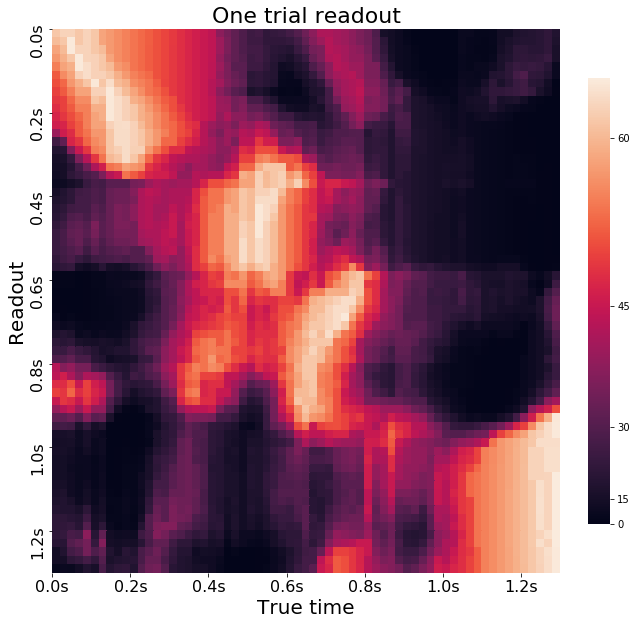

In [185]:
plt.figure(figsize=(10,10))
sns.heatmap(aux[:,:,13],norm=colors.PowerNorm(gamma=4./2.),cbar_kws={'fraction':.04});
xt = np.arange(0,aux.shape[0]+4,10);
plt.title('One trial readout',fontsize=22)
plt.xticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16);
plt.yticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16);
plt.xlabel('True time',fontsize=20);
plt.ylabel('Readout',fontsize=20);

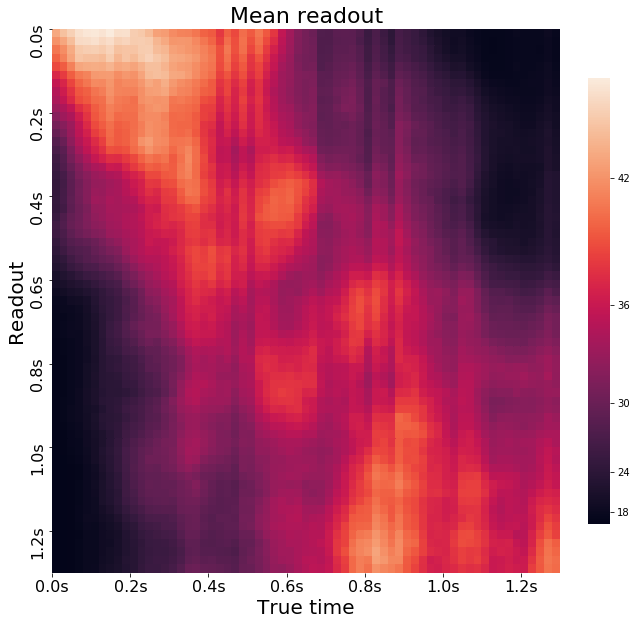

In [182]:
plt.figure(figsize=(10,10))
from matplotlib import colors
sns.heatmap(aux.mean(axis=2),norm=colors.PowerNorm(gamma=4./2.),cbar_kws={'fraction':.04})
plt.title('Mean readout',fontsize=22)
xt = np.arange(0,aux.shape[0]+4,10)
plt.xticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16)
plt.yticks(xt,map(lambda x: str(x*.02)+'s',xt),fontsize=16)
plt.xlabel('True time',fontsize=20);
plt.ylabel('Readout',fontsize=20);

In [ ]:
rat = 8
data = Rat(rat,binSize=20); 
data.selecTrials({'minDuration':1800,'maxDuration':3000,'ntrials':60})
data.selecTimes(tmin=200,tmax=1500)
data.describe()

parameters = loadBestParams(rat)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
aux = temporalGeneralization(data.X, data.y, data.trial, clf,returnDecisionFunc=True)

In [64]:
short = Rat(rat,binSize=50); 
short.selecTrials({'minDuration':1300,'maxDuration':2800,'trialMin':400})
short.selecTimes(tmin=200,tmax=1000)
short.describe()

long = Rat(rat,binSize=50);
long.selecTrials({'minDuration':2800,'trialMin':400})
long.selecTimes(tmin=200,tmax=2500)
long.describe()

aux2,tgen2 = crossGeneralization(long, short, rat)

plt.figure(figsize=(tgen2.shape[1]/5,tgen2.shape[0]/5))
sns.heatmap(tgen2)

Label: Rat 10
Bin size: 50
Sigma: 100

Using 827 trials, according to following restrictions:
minDuration: 1300
maxDuration: 2800
trialMin: 400

Using 16 time bins:
From 200 to 250ms
From 250 to 300ms
From 300 to 350ms
.
.
.
From 900 to 950ms
From 950 to 1000ms


In [41]:

np.argmax(tgen2,axis=0)

array([ 6,  5,  7,  6,  6, 11,  8,  8,  8, 14, 11, 11, 16, 16, 15, 15])

In [253]:
(from spikeHelper.loadSpike import loadSpikeBehav

In [255]:
spike, behav = loadSpikeBehav('Data/rato8tudo.mat')

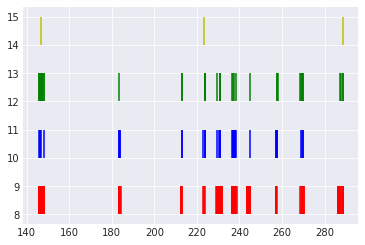

In [287]:
for j in [8,10,12,14]:
    spjs = spike.times[j][spike.times[j]<300]
    plt.vlines(spjs,[0+j for i in spjs],[1+j for i in spjs],colors= ['r','b','g','y'][int(j/2-4)])


In [200]:
r8 = Rat(8,binSize=20);

In [ ]:
r8.

In [ ]:
plt.v

In [168]:
end = Rat(rat,binSize=50); end.selecTrials({'minDuration':1800,'maxDuration':4000,'ntrials':50,'minTrial':'best'});
end.selecTimes(tmin = 0, tmax=3000)


parameters = loadBestParams(rat)
clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
tgen = temporalGeneralization(beg.X, beg.y, beg.trial,clf,returnDecisionFunc=True,returnCubic=True)


KeyboardInterrupt: 

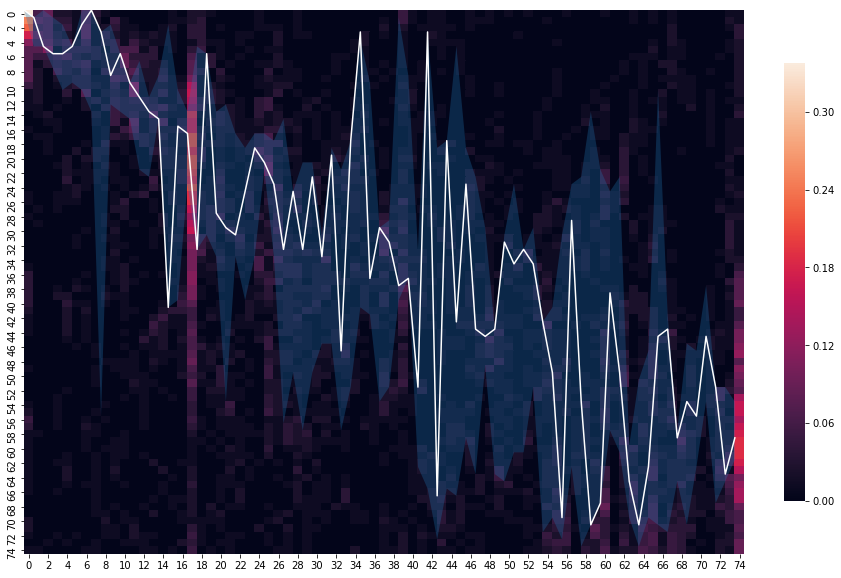

In [172]:
plt.figure(figsize=(14,10))
tg = np.mean(cubic,axis=2)
sns.heatmap(tg,cbar_kws={'fraction':.028})
plt.plot(np.arange(tgen.shape[0]),tg.argmax(axis=0),'w')
sem = np.stack(bootstrap(cubic,lambda x: np.argmax(x.mean(axis=2),axis=0),axis=2,Nboots=4000),1)
conf = np.vstack([confidence(sem[i,:],.68) for i in range(tgen.shape[0])])
plt.fill_between(np.arange(tgen.shape[0]),conf[:,0],np.vstack(conf)[:,1],alpha=.3)
#intPlot(beg,end,rat,performance=True,metric='kappa')

In [118]:
confidence(s[10,:],.68)

array([3, 8])

In [117]:
def confidence(distrib,ci):
    distr = np.sort(distrib)
    total = len(distr)
    i = 1
    inside=1
    while inside > ci:
        roof = distr[-i]
        floor= distr[i]
        inside = np.logical_and(distr>floor, distr<roof).sum()/total
        i+=1
    return np.array([floor, roof])

In [143]:
def bootstrap(matrix,func, axis=0, Nboots=1):
    if Nboots > 1:
        return bootstrap(matrix,func,axis,np.ceil(Nboots/2)) + bootstrap(matrix,func,axis,np.floor(Nboots/2))
    
    samples = np.random.randint(0,matrix.shape[axis],matrix.shape[axis])
    return [func(matrix.take(samples,axis))]

In [77]:
np.random.randint(0,tg.shape[0],tg.shape[0])

array([ 0,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25,
       26, 28, 30, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 47, 48, 50,
       51, 52, 54, 59, 62, 63, 64, 65, 66, 69, 72, 73])

In [ ]:
rat = 8
beg = Rat(rat,binSize=50); beg.selecTrials({'minDuration':1300,'maxDuration':4000,'ntrials':100}); 
beg.selecTimes(tmin = 200, tmax=1000)
end = Rat(rat,binSize=50); end.selecTrials({'minDuration':1300,'maxDuration':6000,'ntrials':100});
end.selecTimes(tmin = 200, tmax=1000)
a, tgen = crossGeneralization(beg, end, rat)
sns.heatmap((tgen))

In [92]:
tgen.take([1,2,3],axis=0).shape

(3, 75, 80)

---

### Time cells from all rats

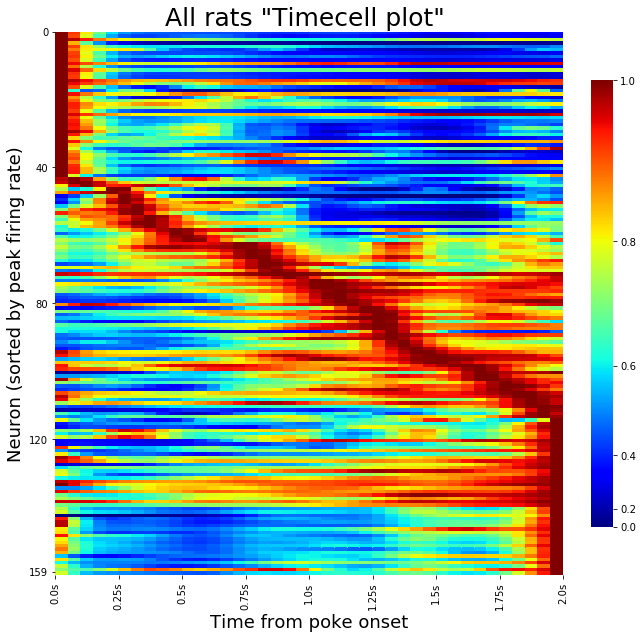

In [195]:
import seaborn as sns

alltCells = []
for rat in [7,8,9,10]:
    r7 = Rat(rat,binSize=50); r7.selecTrials({'minDuration':2200,'maxDuration':8000,'trialMin':'best','ntrials':100}); 
    r7.selecTimes(tmin = 0, tmax=2000)
    t7 = r7.cubicNeuronTimeTrial().mean(axis=2)
    alltCells.append(t7)

from matplotlib import colors

data = np.vstack(alltCells)
#midMean = normRows(data[:,2:38])
meanAct = np.nan_to_num(normRows(data))

plt.figure(figsize=(10,10))
order = np.argsort(np.nonzero(meanAct==1)[1])
sns.heatmap(meanAct[order,:],cmap='jet',norm=colors.PowerNorm(gamma=4./2.),cbar_kws={'fraction':.04})
plt.yticks([0,40,80,120,159],[0,40,80,120,159])
xt = np.arange(0,meanAct.shape[1]+1,5)
plt.xticks(xt,map(lambda x: str(x*.05)+'s',xt)) #'plasma'
plt.title('All rats "Timecell plot" ',fontsize=25)
plt.xlabel('Time from poke onset',fontsize=18)
plt.ylabel('Neuron (sorted by peak firing rate)',fontsize=18)

In [304]:
import seaborn as sns

alltCells = []
for rat in [7,8,9,10]:
    r7 = Rat(rat,binSize=50); r7.selecTrials({'minDuration':3000,'maxDuration':6000,'trialMin':0,'ntrials':80}); 
    r7.selecTimes(tmin = 0, tmax=3000)
    t7 = r7.cubicNeuronTimeTrial().mean(axis=2)
    alltCells.append(t7)

from matplotlib import colors

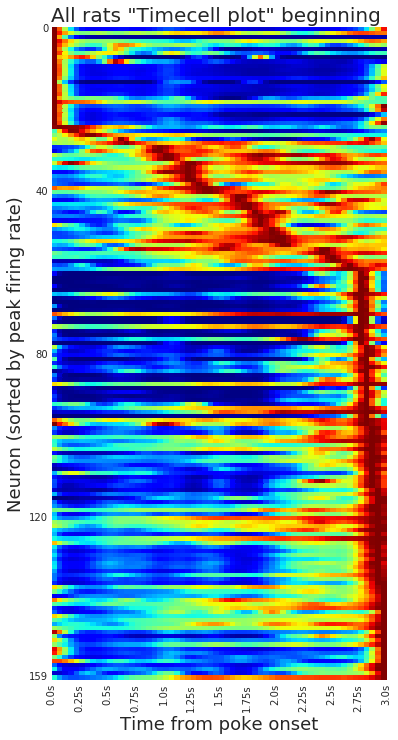

In [305]:
data = np.vstack(alltCells)
#midMean = normRows(data[:,2:38])
meanAct = np.nan_to_num(normRows(data[:,:]))

plt.figure(figsize=(6,12))
order = np.argsort(np.nonzero(meanAct==1)[1])
sns.heatmap(meanAct[order,:],cmap='jet',norm=colors.PowerNorm(gamma=4./2.),cbar=False)#,cbar_kws={'fraction':.02})
plt.yticks([0,40,80,120,159],[0,40,80,120,159])
xt = np.arange(0,meanAct.shape[1]+1,5)
plt.xticks(xt,map(lambda x: str(x*.05)+'s',xt)) #'plasma'
plt.title('All rats "Timecell plot" beginning ',fontsize=20)
plt.xlabel('Time from poke onset',fontsize=18)
plt.ylabel('Neuron (sorted by peak firing rate)',fontsize=18)